In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import sys
sys.path.append('..')

from lib.ChurnEnsemble import ChurnEnsemble

SEED = 42
np.random.seed(SEED)

2024-06-19 16:35:42.918715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
config = dict(
    wtte=dict(
        features=[
            'plan', 'interval', 'country_es', 'country_mx', 'country_latam', 'gateway_auto',
            'failed', 'usage', 'usage_groups', 'usage_payments', 'momentum'
        ],
        params=dict(
            max_sl=24,  # Maximum sequence length
            epochs=100,  # Number of epochs
            lr=1e-4,  # Learning rate
            batch=256,  # Batch size
            stop=30  # Early stopping patience
        )
    ),
    xgb=dict(
        features=[
            'employees', 'interval', 'country_es', 'country_mx', 'country_latam', 'gateway_auto',
            'plan', 'usage', 'usage_groups', 'usage_payments', 'usage_avg',
            'paid_periods', 'months', 'failed_ratio', 'momentum'
        ],
        params=dict(
            n=100,
            lr=1e-2,
            max_depth=16,
            stop=30,
            reg_unb=True
        )
    )
)

min_tte = 1  # Minimum time to event for binary classification (positive if `tte` <= `min_tte`)
test_size = 0.25  # Percentage of the data to use for test/validation

In [3]:
data = pd.read_csv('../files/churn-data-fit.csv')

data

,cid,id,tp,tfs,tte,ts,te,employees,mrr,value,...,usage_avg,usage_groups_avg,usage_payments_avg,paid_periods,failed_periods,active_periods,momentum,months,failed_ratio,usage_diff
0,51b46d18c4de615d0f000019,1,2017-07-01,4.0,-1.0,2017-03-01,NaN,1,26.58,159.50,...,2.00,0.0,0.0,0.0,0.0,1.0,0.00,4.0,NaN,0.00
1,51b46d18c4de615d0f000019,1,2017-08-01,5.0,-1.0,2017-03-01,NaN,1,26.58,159.50,...,2.00,0.0,0.0,0.0,0.0,2.0,1.20,5.0,NaN,0.00
2,51b46d18c4de615d0f000019,1,2017-09-01,6.0,-1.0,2017-03-01,NaN,1,26.58,239.25,...,2.00,0.0,0.0,1.0,0.0,3.0,-3.14,6.0,0.0,0.00
3,51b46d18c4de615d0f000019,1,2017-10-01,7.0,-1.0,2017-03-01,NaN,1,26.58,239.25,...,1.75,0.0,0.0,1.0,0.0,3.0,-13.60,7.0,0.0,-0.75
4,51b46d18c4de615d0f000019,1,2017-11-01,8.0,-1.0,2017-03-01,NaN,1,26.58,239.25,...,1.60,0.0,0.0,1.0,0.0,3.0,-18.57,8.0,0.0,-0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201230,66633bcee489710bb6afe3d9,11065,2024-06-01,0.0,-1.0,2024-06-01,NaN,1,101.97,101.97,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
201231,666346aee489710bb6afead3,11066,2024-06-01,0.0,-1.0,2024-06-01,NaN,1,40.00,40.00,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
201232,66634aea1e0bd65a73bf4f2f,11067,2024-06-01,0.0,-1.0,2024-06-01,NaN,1,46.62,46.62,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
201233,666388b3e489710bb6b00925,11068,2024-06-01,0.0,-1.0,2024-06-01,NaN,1,60.19,60.19,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00


In [4]:
# Instantiate Ensemble model, set parameters and data
model = ChurnEnsemble(
    min_tte=min_tte,
    seed=SEED,
    verbose=1,
    path='../files',
    **config
).set_data(
    data,
    test_size=test_size
).build_model()

model.params

Total Customers: 11.069 | Censored: 2.678 | Non-censored: 8.391 | Censored Rate 24,19%
Train: 8.301 (24,19%) | Test: 2.768 (24,21%)


{'wtte': {'max_sl': 24,
  'nn': 0,
  'hl': 2,
  'lr': 0.0001,
  'epochs': 100,
  'batch': 256,
  'hl_func': 'tanh',
  'lr_decay': 0,
  'stop': 30,
  'kind': 'discrete',
  'dropout': 0.2,
  'weight_l1': 0,
  'weight_l2': 1e-05,
  'init_alpha': None,
  'reg_alpha': True,
  'max_beta': 2.0,
  'epsilon': 1e-08,
  'shuffle': False},
 'xgb': {'n': 100,
  'lr': 0.01,
  'max_depth': 16,
  'stop': 30,
  'metric': 'auc',
  'min_child_weight': 1,
  'gamma': 0,
  'weight_l1': 0,
  'weight_l2': 1,
  'dropout': 0.2,
  'shuffle': False,
  'reg_unb': True}}

In [8]:
# Fit WTTE model
model.fit_wtte()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 11)          0         
                                                                 
 lstm (LSTM)                 (None, None, 24)          3456      
                                                                 
 batch_normalization (Batch  (None, None, 24)          96        
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, None, 24)          4704      
                                                                 
 batch_normalization_1 (Bat  (None, None, 24)          96        
 chNormalization)                                                
                                                                 
 time_distributed (TimeDist  (None, None, 2)           5

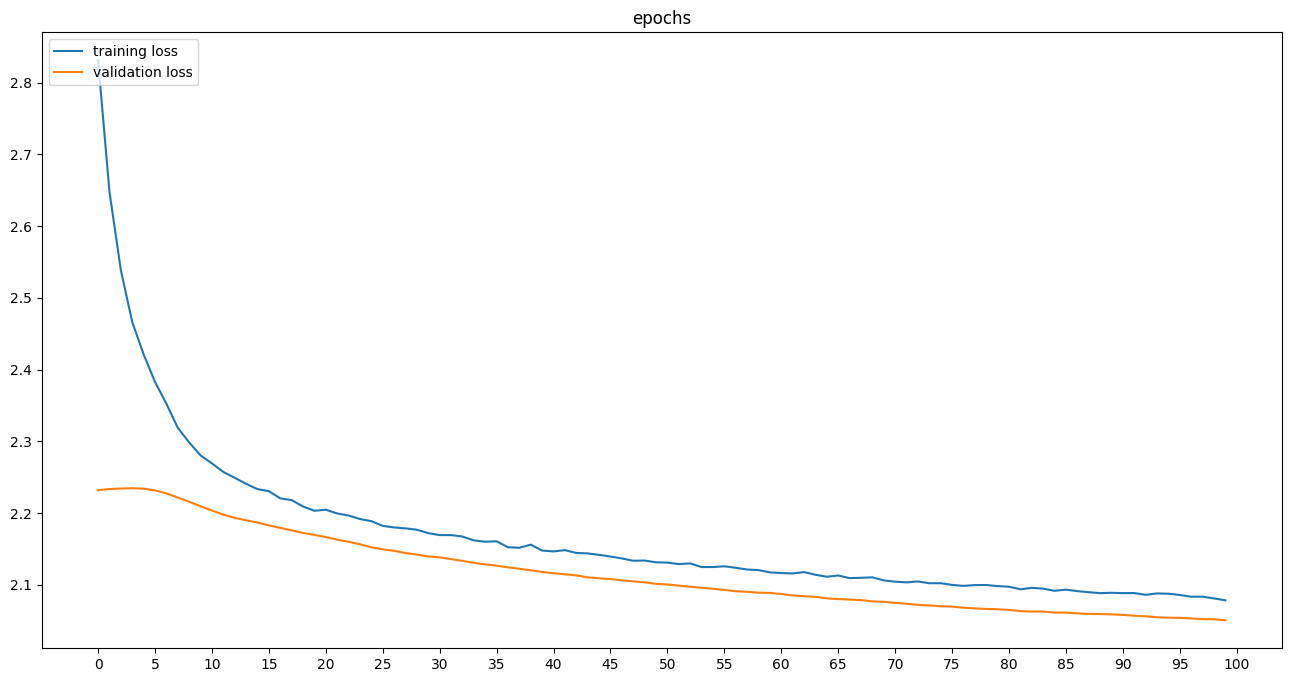

In [9]:
# Plot training history
model.wtte.plot_history_eval()

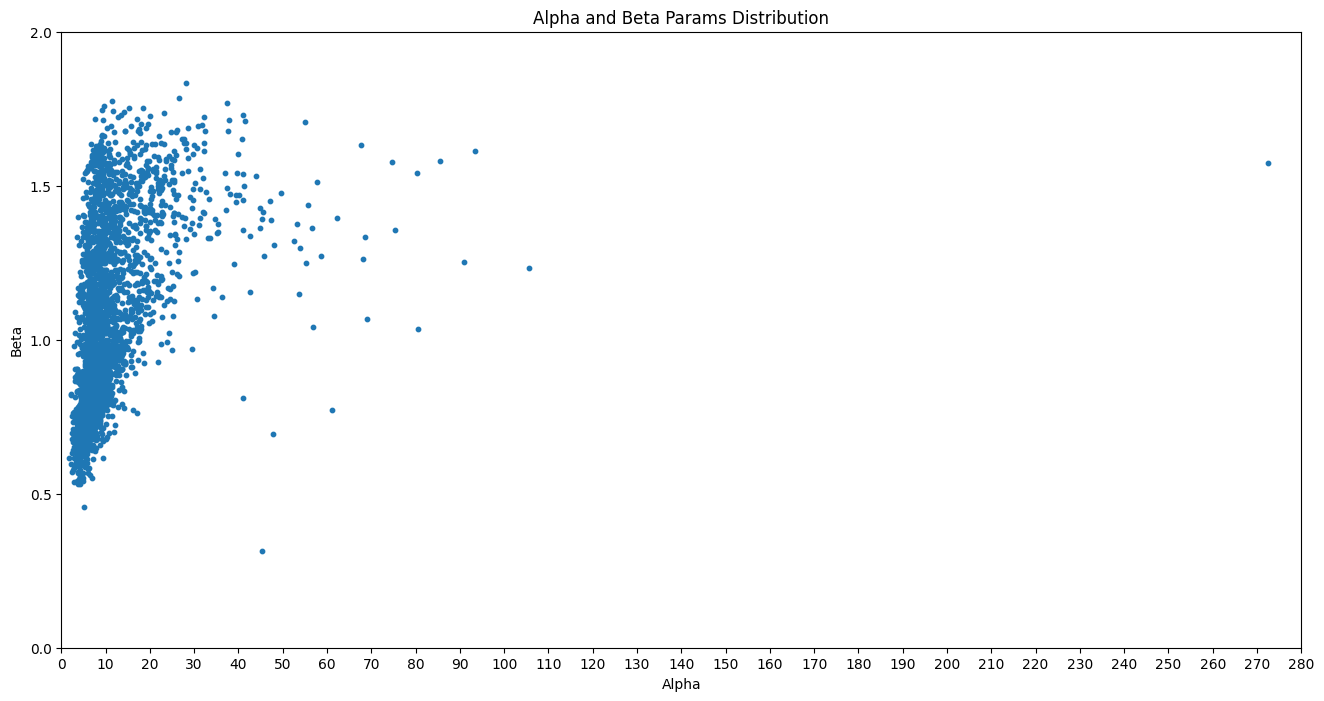

In [10]:
# Plot parameters distribution
model.wtte.plot_params_dist(model.wtte.results, loc=-1)

In [11]:
# Fit XGBoost model
model.fit_xgb()

2544/2544 [==============================] - 17s 7ms/step
[0]	validation_0-auc:0.92656	validation_1-auc:0.82216
[1]	validation_0-auc:0.94731	validation_1-auc:0.83906
[2]	validation_0-auc:0.95544	validation_1-auc:0.84753
[3]	validation_0-auc:0.95888	validation_1-auc:0.85518
[4]	validation_0-auc:0.96101	validation_1-auc:0.85944
[5]	validation_0-auc:0.96288	validation_1-auc:0.86143
[6]	validation_0-auc:0.96402	validation_1-auc:0.86271
[7]	validation_0-auc:0.96507	validation_1-auc:0.86538
[8]	validation_0-auc:0.96538	validation_1-auc:0.86599
[9]	validation_0-auc:0.96609	validation_1-auc:0.86632
[10]	validation_0-auc:0.96648	validation_1-auc:0.86738
[11]	validation_0-auc:0.96709	validation_1-auc:0.86856
[12]	validation_0-auc:0.96730	validation_1-auc:0.86867
[13]	validation_0-auc:0.96751	validation_1-auc:0.86925
[14]	validation_0-auc:0.96789	validation_1-auc:0.86954
[15]	validation_0-auc:0.96800	validation_1-auc:0.87044
[16]	validation_0-auc:0.96828	validation_1-auc:0.87131
[17]	validation_0

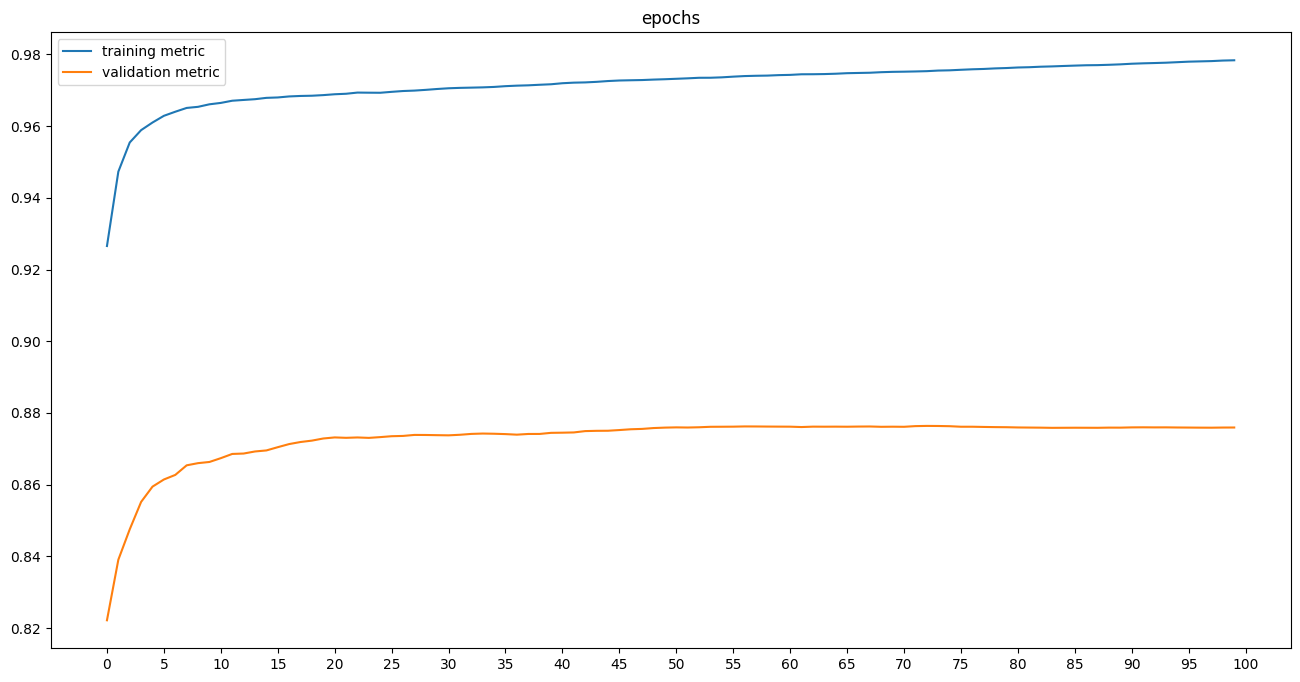

In [12]:
# Plot training history
model.xgb.plot_history_eval()

In [13]:
# Compute and set model scores
model.set_scores()
# Set model results from XGBoost predictions
model.set_results()

model.results

,id,tfs,pred,true,tgt,segment,wa,wb,momentum,cid
0,9,4,0.374766,0.0,1,4,15.491422,1.082160,0.00,51f5447aa4dcd3245d000036
1,9,5,0.386831,0.0,1,4,16.357903,1.034003,0.38,51f5447aa4dcd3245d000036
2,9,6,0.314552,0.0,1,4,20.309654,1.106676,0.32,51f5447aa4dcd3245d000036
3,9,7,0.320922,1.0,1,4,20.160822,1.129292,-0.70,51f5447aa4dcd3245d000036
4,9,8,0.618615,1.0,1,5,17.463259,1.062156,-6.75,51f5447aa4dcd3245d000036
...,...,...,...,...,...,...,...,...,...,...
50570,11062,0,0.550239,0.0,1,5,11.729210,0.994957,0.00,6661e576a98733f247acc46c
50571,11063,0,0.564701,0.0,1,5,10.482958,0.979066,0.00,6661e7dfa98733f247acc5cd
50572,11064,0,0.627057,0.0,1,5,10.677544,0.978387,0.00,666227321e0bd65a73be6c31
50573,11065,0,0.592812,0.0,1,5,10.389841,0.978127,0.00,66633bcee489710bb6afe3d9


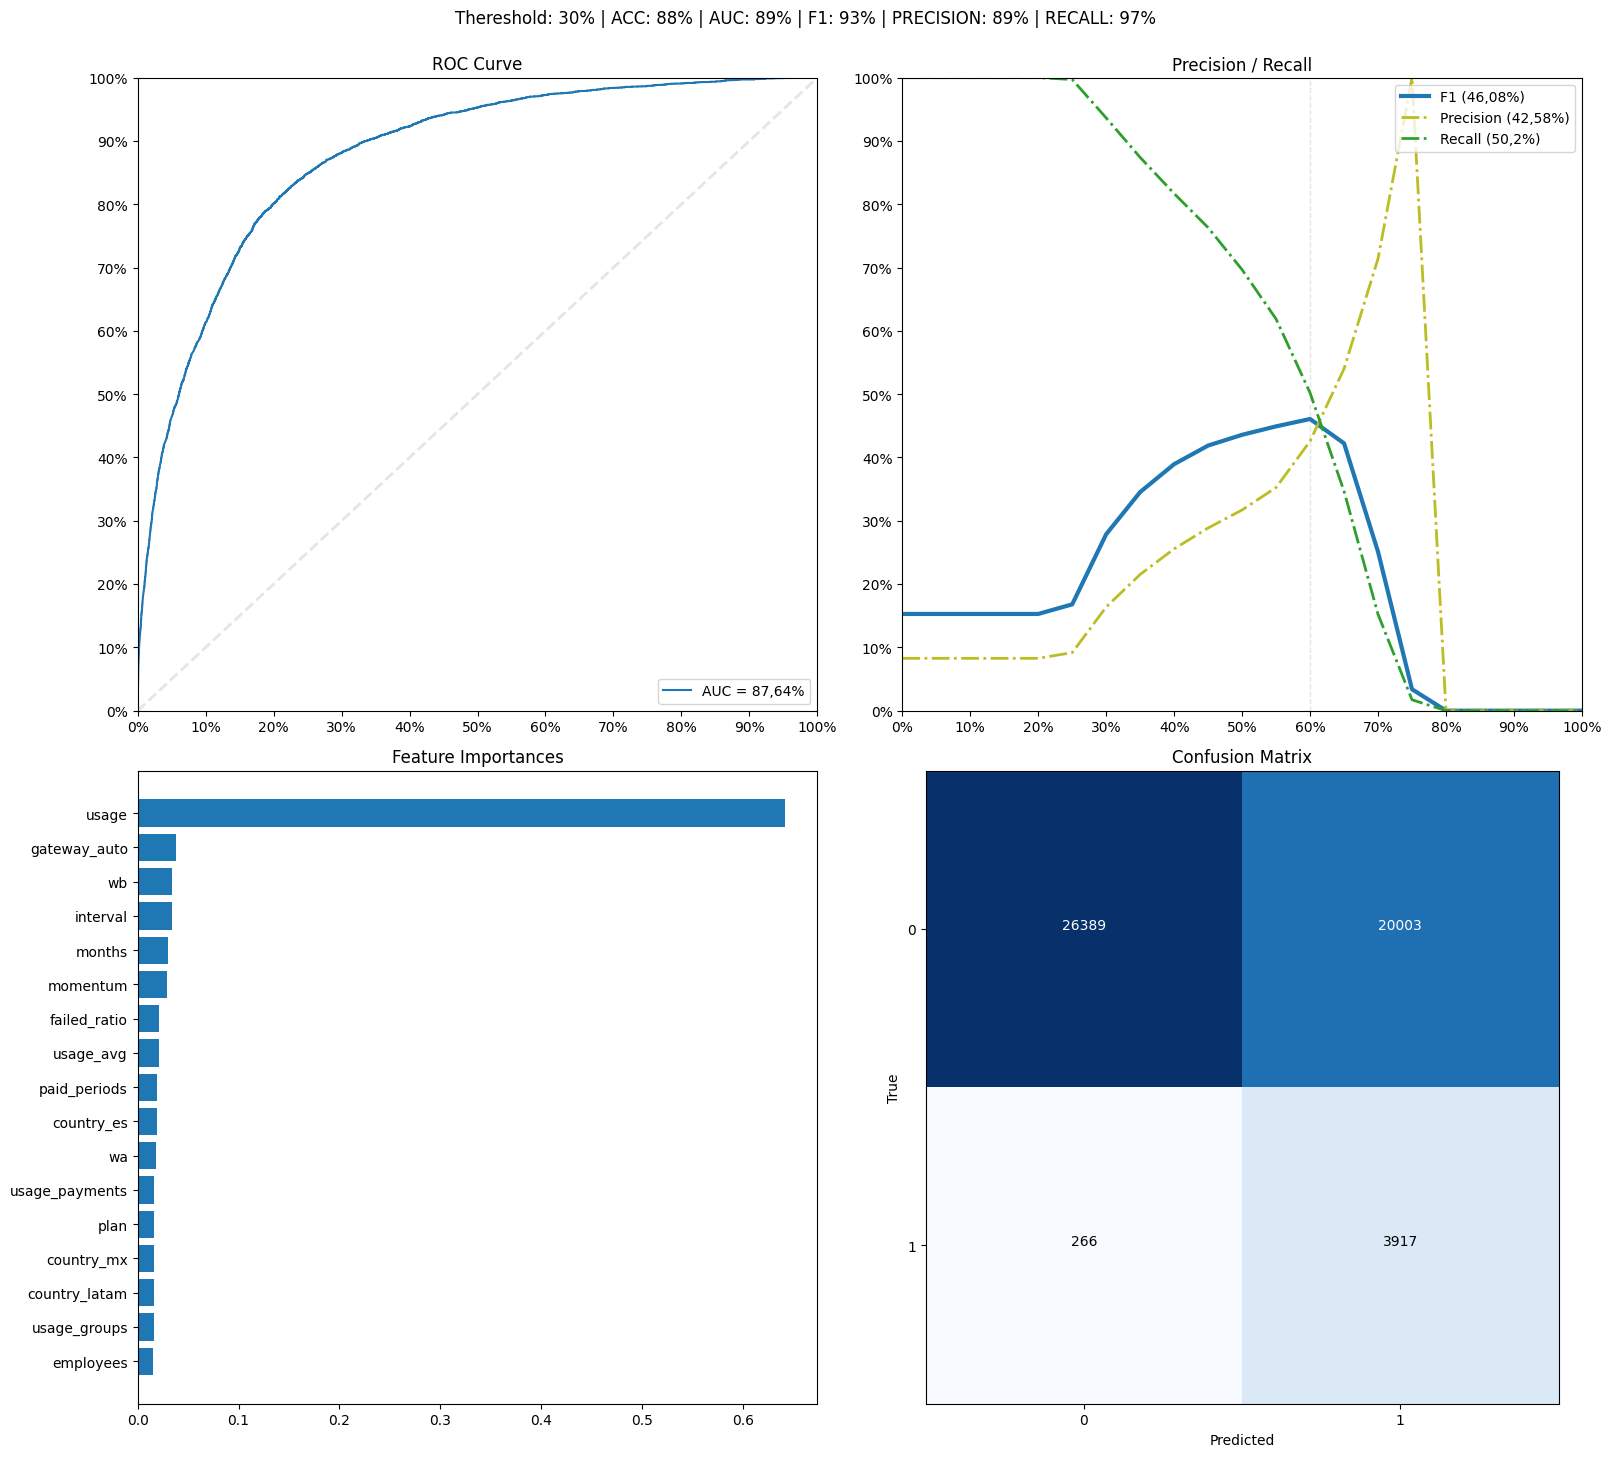

In [14]:
model.save()

# Plot scores summary
model.plot_scores()

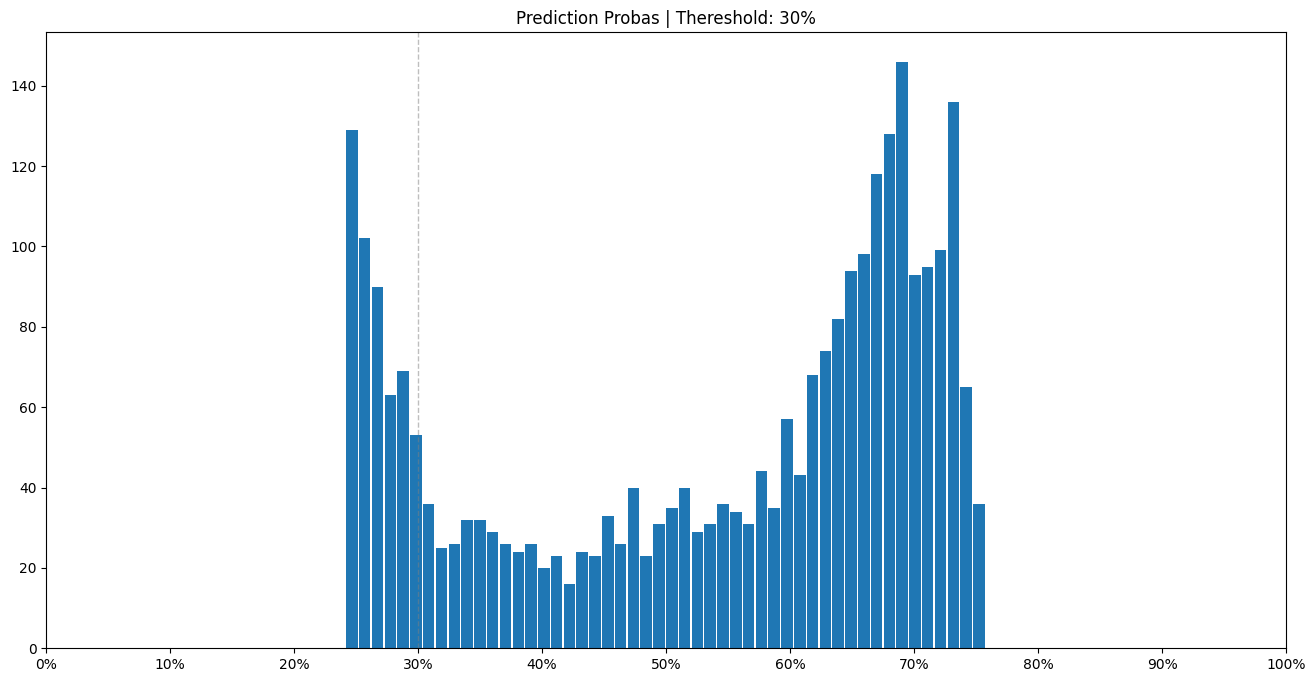

In [15]:
# Plot histogram of predicted probabilities for each customer sequence
model.plot_histogram()